# Trabalho #3 - Ajuste de função e métodos de otimização

Nesse trabalho você vai desenvolver uma rede neural deep-learning usando a plataforma TensorFlow-Keras, para realizar uma tarefa de ajuste de função e testar diferentes algorimos de otimização.

A função que será aprendida pela RNA nesse trabalho é o cálculo da orientação de um objeto no espaço tendo como dados as medidas de uma UMI (Unidade de Medida Inercial). Uma UMI possui 9 sensores: 3 acelerômetros, 3 magnetômetros e 3 giroscópios. Portanto, para cada eixo de um sistema de coordenadas cartesiano tem-se as medidas de um acelerômetro, um magnetômetro e um giroscópio. Assim, uma UMI mede as três componentes da aceleração linear, do vetor do campo magnético e da velocidade angular em cada eixo.

Nesse trabalho você também vai utilizar métodos de otimização avançados, que aceleram o processo de treinamento da RNA e, assim, talvez obter um desempenho melhor. Um algoritmo de otimização eficiente pode fazer a diferença entre esperar dias ou apenas alguns minutos para obter bons resultados.

## Coloque o seu nome aqui.

Aluno: Matias Herklotz

Para iniciar, execute a célula abaixo para importar algumas bilbiotecas básicas que usaremos nesse trabalho e iniciar o gerador de números aleatórios.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

np.random.seed(5)


## 1 - Visão geral do problema

A localização e navegação de veículos autônomos é um tópico importante para a área de robôs móveis. Em particular, a obtenção da orientação de um veículo autônomo aéreo é fundamental para o seu controle e representa um desafio importante e difícil a ser abordado. Muitos métodos calculam a orientação usando dados de uma UMI e algorítmos baseados em filtro de Kalman, filtro de partículas, filtros complementares etc. Porém, esses métodos são complicados e as grandes incertezas associadas às medidas das UMI de baixo custo fazem com que os resultados calculados para a orientação do veículo não sejam muito satisfatórios.

Nesse trabalho é fornecido um arquivo com os dados de treinamento que contém:

- medidas de 6 sensores de uma UMI (3 acelerômetros e 3 magnetômetros);
- resultados da orientação do veículo em relação aos 3 eixos do sistema de coordenadas fixo;
- cada linha do arquivo representa um conjunto de dados da UMI e a orientação real do objeto.

Observa-se que nesse trabalho não serão usadas as medidas dos giroscópios, pois se fossem usados seria preciso usar uma rede com camadas recorrentes, que é capaz de processar séries temporais.

A partir desse conjunto de dados, a sua tarefa é desenvolver um sistema baseado em uma rede neural, para calcular a orientação do veículo no espaço 3D. Para isso, você vai desenvolver algumas redes neurais usando a ferramenta TensorFlow-Keras e comparar o desempenho delas. 

**Referência:** Os dados utilizados nesse trabalho foram obitidos de: Barsocchi, P., Crivello, A., La Rosa, D. e Palumbo, F. (2016, October). A multisource and multivariate dataset for indoor localization methods based on WLAN and geo-magnetic field fingerprinting. In Indoor Positioning and Indoor Navigation (IPIN), 2016 International Conference on (pp. 1-8). IEEE.

## 2 - Dados de treinamento

Os dados que iremos utilizar nesse trabalho estão no arquivo measurements.csv. Cada linha desse arquivo representa uma medida da UMI.

As colunas desse arquivo representam as seguintes grandezas:

- coluna #1: instante de tempo da medidida;
- colunas #2 a #4: valores da aceleração linear nos eixos x, y e z do sistema de coordenadas fixo no veículo;
- colunas #5 a #7: valores da inclinação do campo magnético nos eixos x, y e z do sistema de coordenadas fixo no veículo;
- colunas #8 a #10: valores da orientação do veículo em relação aos eixos x, y e z do sistema de coordenadas fixo no ambiente (angulos de yaw, pitch e roll);

### 2.1 - Leitura dos dados

Para iniciar o trabalho é necessário ler o arquivo de dados e transformá-lo em um tensor numpy. Assim, execute o código da célula abaixo.

In [49]:
# Leitura do arquivo de dados
measurements = np.loadtxt('measurements.csv', delimiter=",",  skiprows=1, usecols=[1,2,3,4,5,6,7,8,9])
dados = np.array(measurements)
print(dados.shape)
print(dados[10])


(58374, 9)
[-2.8000e-02  3.5510e+00  8.9710e+00 -1.3790e+00  3.0300e+00 -4.5880e+01
  2.3020e+00 -2.1501e+01  2.6000e-02]


A dimensão do tensor com os dados é: 58374 linhas e 9 colunas. Portanto temos 58374 exemplos que podem ser usados como dados de treinamento, validação e teste. 

A décima linha do arquivo de dados foi impressa para se ter um ideia de como são os dados. Note que não usaremos nesse trabalho o instante de tempo da realização das medidas que aparece na primeira coluna, portanto, essa coluna foi descartada.

### 2.2 - Processamento dos dados

Para os dados poderem ser usados para o desenvolvimento da RNA devemos processá-los de várias formas.

### Exercício #1: Embaralhamento aleatório dos dados

Como os dados foram obtidos em uma sequencia temporal, cada linha está correlacionada com as linhas anteriores. Porém, como vamos usar esses dados somente para calcular a orientação do veículo, podemos considerar que cada linha representa uma medida independente. Assim, primeiramente vamos misturar as linhas com os dados para ter certeza que cada medida não esteja correlacionada com as medidas anteriores. 

Crie um código que embaralha os dados (linhas) e coloque as 6 primeiras colunas do tensor "dados" em um tensor de entradas "x" e as 3 últimas colunas do tensor "dados" em um tensor de saída "y". Para isso, use:

- a função numpy `random.shuffle(nome_tensor)` para realizar a tarefa de misturar as linhas de forma aleatória ([Dica])(https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html);

In [50]:
# PARA VOCÊ FAZER: Embaralhamento das linhas do arquivo de dados

np.random.seed(3)

### COMECE AQUIE ### (≈ 3 linhas)
np.random.shuffle(dados)
x = dados[:,0:6]
y = dados[:,6:9]
### TERMINE AQUI ###

print("Dimensão dos dados de entrada = ", x.shape)
print("Dimensão dos dados de saída = ", y.shape)
print("Décima linha do tensor de dados misturados:", dados[10])
print("Décima linha do tensor com os dados de entrada = ", x[10])
print("Décima linha do tensor com os dados de saída = ", y[10])


Dimensão dos dados de entrada =  (58374, 6)
Dimensão dos dados de saída =  (58374, 3)
Décima linha do tensor de dados misturados: [ -7.81   -5.113   3.471  45.557  -1.393  -0.743 287.665  54.653 -49.401]
Décima linha do tensor com os dados de entrada =  [-7.81  -5.113  3.471 45.557 -1.393 -0.743]
Décima linha do tensor com os dados de saída =  [287.665  54.653 -49.401]


**Saída esperada:**

    Dimensão dos dados de entrada =  (58374, 6)
    Dimensão dos dados de saída =  (58374, 3)
    Décima linha do tensor de dados misturados: [ -7.81   -5.113   3.471  45.557  -1.393  -0.743 287.665  54.653 -49.401]
    Décima linha do tensor com os dados de entrada =  [-7.81  -5.113  3.471 45.557 -1.393 -0.743]
    Décima linha do tensor com os dados de saída =  [287.665  54.653 -49.401]

**Visualização dos dados:**
    
Execute a célula abaixo para visualizar os dados de entrada e de saída. 

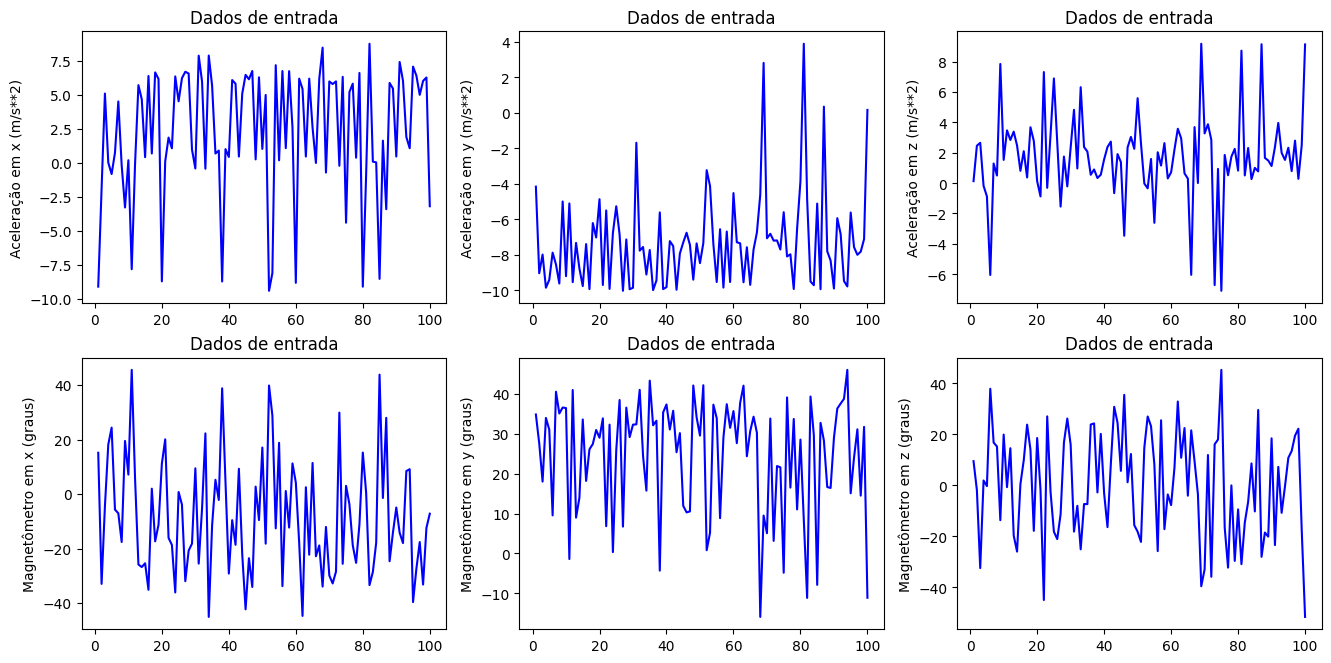

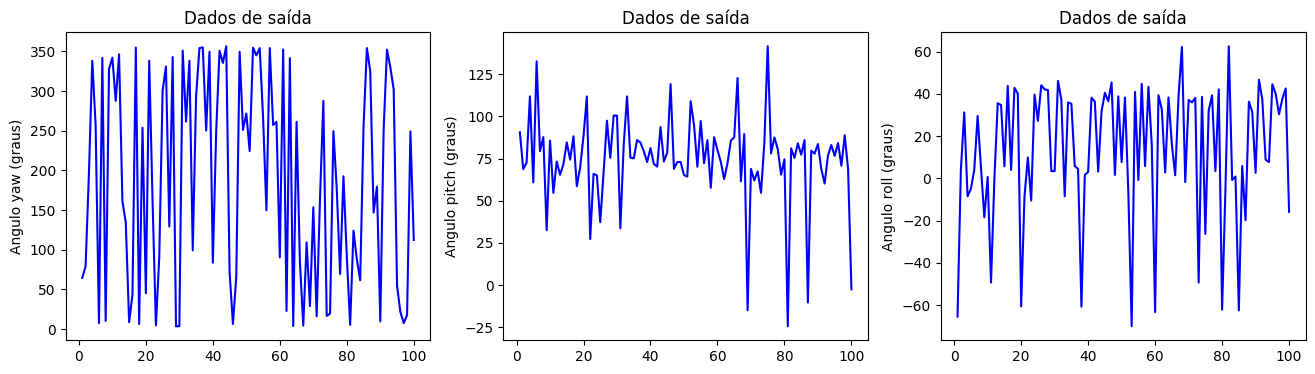

In [51]:
# Visualização dos dados
num = range(1, len(x) + 1)

plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 1)
plt.plot(num[0:100], x[0:100,0], 'b')
plt.title('Dados de entrada')
plt.ylabel('Aceleração em x (m/s**2)')

plt.subplot(3, 3, 2)
plt.plot(num[0:100], x[0:100,1], 'b')
plt.title('Dados de entrada')
plt.ylabel('Aceleração em y (m/s**2)')

plt.subplot(3, 3, 3)
plt.plot(num[0:100], x[0:100,2], 'b')
plt.title('Dados de entrada')
plt.ylabel('Aceleração em z (m/s**2)')

plt.subplot(3, 3, 4)
plt.plot(num[0:100], x[0:100,3], 'b')
plt.title('Dados de entrada')
plt.ylabel('Magnetômetro em x (graus)')

plt.subplot(3, 3, 5)
plt.plot(num[0:100], x[0:100,4], 'b')
plt.title('Dados de entrada')
plt.ylabel('Magnetômetro em y (graus)')

plt.subplot(3, 3, 6)
plt.plot(num[0:100], x[0:100,5], 'b')
plt.title('Dados de entrada')
plt.ylabel('Magnetômetro em z (graus)')
plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(num[0:100], y[0:100,0], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo yaw (graus)')
plt.subplot(1, 3, 2)
plt.plot(num[0:100], y[0:100,1], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo pitch (graus)')
plt.subplot(1, 3, 3)
plt.plot(num[0:100], y[0:100,2], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo roll (graus)')
plt.show()


### Exercício #2: Divisão dos dados nos conjuntos de treinamento, validação e teste

Precisamos separar os dados nos conjuntos de treinamento, validação e teste. Como temos cerca de 60000 exemplos podemos separar os dados, podemos fazer a seguinte divisão:

- Dados de treinamento: 38.374 exemplos;
- Dados de validação: 10.000 exemplos;
- Dados de teste: 10.000 exemplos.

In [52]:
# PARA VOCÊ FAZER: Divisão dos exemplos em dados de treinamento, validação e teste

# Dados de entrada:
### COMECE AQUI ### (≈ 3 linhas)
x_train = x[0:38374]
x_val = x[38374:48374]
x_test = x[48374:58374]
### TERMINE AQUI ###

# Dados de saída
### COMECE AQUIE ### (≈ 3 linhas)
y_train = y[0:38374]
y_val = y[38374:48374]
y_test = y[48374:58374]
### TERMINE AQUI ###

m = len(x_train)
print("Número de exemplos de treinamento = ", m)
print("Dimensão do tensor de dados de entrada de treinamento =", x_train.shape)
print("Dimensão do tensor de dados de entrada de validação =", x_val.shape)
print("Dimensão do tensor de dados de entrada de teste =", x_test.shape)
print("Dimensão do tensor de dados de saída de treinamento =", y_train.shape)
print("Dimensão do tensor de dados de saída de validação =", y_val.shape)
print("Dimensão do tensor de dados de saída de teste =", y_test.shape)


Número de exemplos de treinamento =  38374
Dimensão do tensor de dados de entrada de treinamento = (38374, 6)
Dimensão do tensor de dados de entrada de validação = (10000, 6)
Dimensão do tensor de dados de entrada de teste = (10000, 6)
Dimensão do tensor de dados de saída de treinamento = (38374, 3)
Dimensão do tensor de dados de saída de validação = (10000, 3)
Dimensão do tensor de dados de saída de teste = (10000, 3)


**Saída esperada:**

    Número de exemplos de treinamento =  38374
    Dimensão do tensor de dados de entrada de treinamento = (38374, 6)
    Dimensão do tensor de dados de entrada de validação = (10000, 6)
    Dimensão do tensor de dados de entrada de teste = (10000, 6)
    Dimensão do tensor de dados de saída de treinamento = (38374, 3)
    Dimensão do tensor de dados de saída de validação = (10000, 3)
    Dimensão do tensor de dados de saída de teste = (10000, 3)

### Exercício #3: Normalização dos dados de entrada

Pode-se observar que os dados de entrada e de saída apresentam valores com grandes variações. As medidas dos acelerômetros variam entre -10 m/s^2 a +10 m/s^2, as medidas dos magnetômetros variam entre -40 graus a +60 graus e os ângulos de roll, pitch e yam variam entre -60 graus a 350 graus. O ideal para esse tipo de dado é serem normalizados para que todas as medidas fiquem com média zero e desvio padrão igual a um. 

Crie um código na célula abaixo que calcula a média e o desvio padrão de cada coluna dos dados de entrada e de saída do conjunto de treinamento e use esses valores para normalizar os dados de entrada e de saída dos conjuntos de treinamento, validação e  teste. 

**Importante:** os dados de validação e de teste devem ser normalizados com a média e desvio padrão dos dados de treinamento  para evitar usar informações desses dois conjuntos de dados no treinamento da rede.

Para calcular a média e o desvio padrão das colunas de uma matriz A, use as funções da biblioteca numpy mean e std da seguinte forma:

- `media_das colunas = A.mean(axis=0)`
- `std_das_colunas = A.std(axis=0)`

Nos comando acima (`axis=0`) significa que é desejado calcular as médias e desvios padrão de cada coluna individualmente.


In [53]:
# PARA VOCÊ FAZER: Normalização dos dados

# Calculo das médias e desvios padrão dos dados de entrada do conjunto de treinamento
### COMECE AQUI ### (≈ 2 linhas)
meanx = np.mean(x_train, axis=0)
stdx = np.std(x_train, axis=0)
### TERMINE AQUI ###

# Normalização das entradas dos dados de treinamento, validação e teste usando as médias meanx e os desvios padrão stdx.
### COMECE AQUI ### (≈ 3 linhas)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
### TERMINE AQUI ###

# Calculo das médias e desvios padrão dos dados de saida do conjunto de treinamento
### COMECE AQUI ### (≈ 2 linhas)
meany = np.mean(y_train, axis=0)
stdy = np.std(y_train, axis=0)
### TERMINE AQUI ###

# Normalização das saídas dos dados de treinamento, validação e teste usando as médias meany e os desvios padrão stdy.
### COMECE AQUI ### (≈ 3 linhas)
y_train_norm = (y_train - meany)/stdy
y_val_norm = (y_val - meany)/stdy
y_test_norm  = (y_test - meany)/stdy

# impressão dos resultados para verificação
print("Médias entradas dados originais = ", meanx)
print("Desvios padrão entradas dados originais = ", stdx)
print("Médias entradas dados normalizados = ", x_train_norm.mean(axis=0))
print("Desvios padrão entradas dados normalizados = ", x_train_norm.std(axis=0))
print("Primeira linha entradas dados treinamento não normalizados = ", x_train[0])
print("Primeira linha entradas dados treinamento normalizados = ", x_train_norm[0])
print("Médias saidas dados originais = ", meany)
print("Desvios padrão saidas dados originais = ", stdy)
print("Médias saidas dados normalizados = ", y_train_norm.mean(axis=0))
print("Desvios padrão saidas dados normalizados = ", y_train_norm.std(axis=0))


Médias entradas dados originais =  [ 1.74230164 -7.08103773  1.92199898 -4.83301571 23.52253721  0.80696315]
Desvios padrão entradas dados originais =  [ 4.55702576  3.19518916  3.33826157 20.44909397 16.39709647 20.96033074]
Médias entradas dados normalizados =  [-2.10620076e-15 -1.91982772e-14 -2.43274358e-15 -9.22850106e-16
  3.75324471e-16  6.71908572e-17]
Desvios padrão entradas dados normalizados =  [1. 1. 1. 1. 1. 1.]
Primeira linha entradas dados treinamento não normalizados =  [-9.089 -4.167  0.127 15.138 34.79   9.439]
Primeira linha entradas dados treinamento normalizados =  [-2.37683573  0.91200789 -0.53770471  0.97662105  0.68716207  0.41182732]
Médias saidas dados originais =  [198.15801941  71.70565208  10.493674  ]
Desvios padrão saidas dados originais =  [126.31954808  35.51320872  30.12788744]
Médias saidas dados normalizados =  [-5.98762713e-15  1.01556326e-13  2.98303798e-15]
Desvios padrão saidas dados normalizados =  [1. 1. 1.]


**Saída esperada:**

    Médias entradas dados originais =  [ 1.74230164 -7.08103773  1.92199898 -4.83301571 23.52253721  0.80696315]
    Desvios padrão entradas dados originais =  [ 4.55702576  3.19518916  3.33826157 20.44909397 16.39709647 20.96033074]
    Médias entradas dados normalizados =  [-2.10620076e-15 -1.91982772e-14 -2.43274358e-15 -9.22850106e-16  3.75324471e-16  6.71908572e-17]
    Desvios padrão entradas dados normalizados =  [1. 1. 1. 1. 1. 1.]
    Primeira linha entradas dados treinamento não normalizados =  [-9.089 -4.167  0.127 15.138 34.79  9.439]
    Primeira linha entradas dados treinamento normalizados =  [-2.37683573  0.91200789 -0.53770471  0.97662105  0.68716207  0.41182732]
    Médias saidas dados originais =  [198.15801941  71.70565208  10.493674  ]
    Desvios padrão saidas dados originais =  [126.31954808  35.51320872  30.12788744]
    Médias saidas dados normalizados =  [-5.98762713e-15  1.01556326e-13  2.98303798e-15]
    Desvios padrão saidas dados normalizados =  [1. 1. 1.]
      
**Observações:**      
- As médias das entradas dos dados normalizados devem ser 6 valores muito próximos de zero, como é de se esperar;
- A primeira linha dos dados de entrada treinamento não normalizados e a primeira linha dos dados normalizados servem como indicação de que os cálculos foram realizados de forma correta;
- As médias das saidas dos dados normalizados devem ser 2 valores muito próximos de zero, como é de se esperar.

Execute a célula abaixo para visulizar os gráficos dos dados de entrada e de saída normalizados do conjunto de exemplos de treinamento.

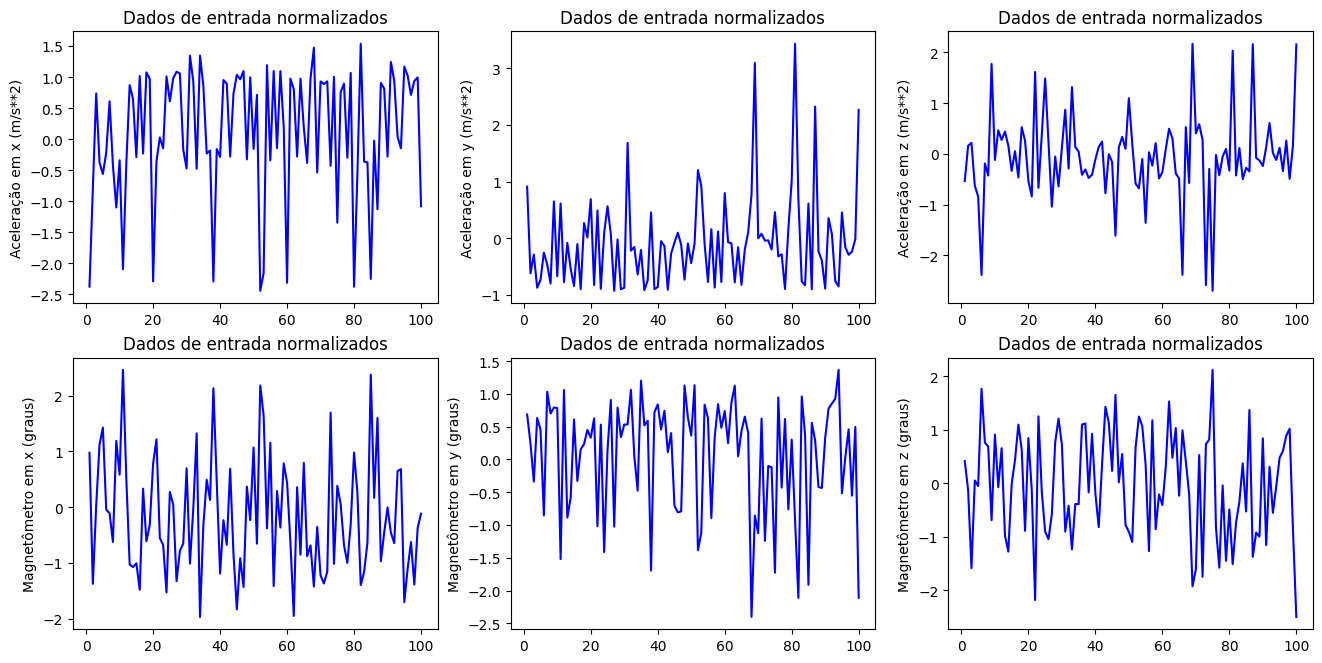

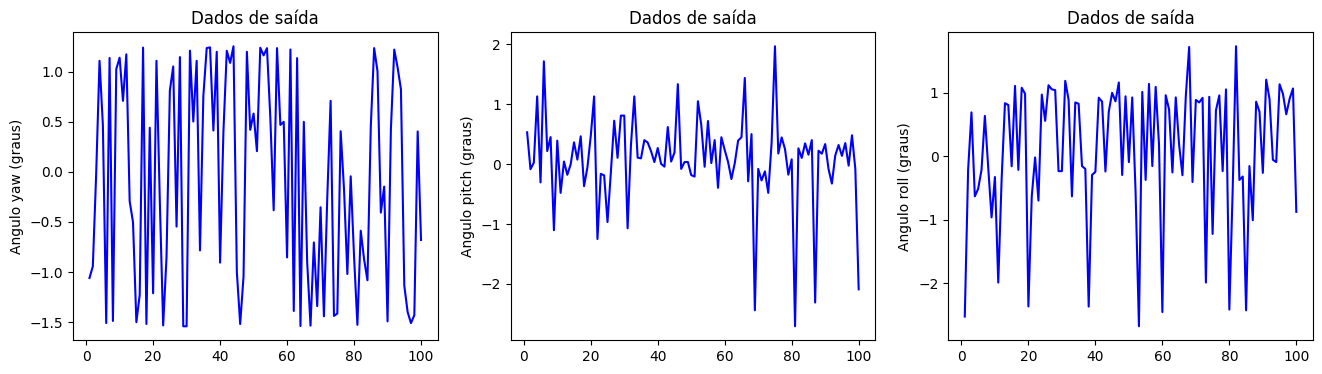

In [54]:
# Visualização dos dados de treinamento
num = range(1, len(x) + 1)

plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 1)
plt.plot(num[0:100], x_train_norm[0:100,0], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Aceleração em x (m/s**2)')

plt.subplot(3, 3, 2)
plt.plot(num[0:100], x_train_norm[0:100,1], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Aceleração em y (m/s**2)')

plt.subplot(3, 3, 3)
plt.plot(num[0:100], x_train_norm[0:100,2], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Aceleração em z (m/s**2)')

plt.subplot(3, 3, 4)
plt.plot(num[0:100], x_train_norm[0:100,3], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Magnetômetro em x (graus)')

plt.subplot(3, 3, 5)
plt.plot(num[0:100], x_train_norm[0:100,4], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Magnetômetro em y (graus)')

plt.subplot(3, 3, 6)
plt.plot(num[0:100], x_train_norm[0:100,5], 'b')
plt.title('Dados de entrada normalizados')
plt.ylabel('Magnetômetro em z (graus)')
plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(num[0:100], y_train_norm[0:100,0], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo yaw (graus)')
plt.subplot(1, 3, 2)
plt.plot(num[0:100], y_train_norm[0:100,1], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo pitch (graus)')
plt.subplot(1, 3, 3)
plt.plot(num[0:100], y_train_norm[0:100,2], 'b')
plt.title('Dados de saída')
plt.ylabel('Angulo roll (graus)')
plt.show()


## 3 - Configuração da RNA

Nesse problema de ajuste de função deseja-se desenvolver uma RNA que aprenda a função que transforma os dados de entrada nos dados de saída. No problema de calcular a orientação de um veículo móvel usando dados de acelerômetros e magnetômetros, temos um conjunto de 6 equações não lineares cuja solução fornece os ângulos de yaw, pitch e roll, que representam a orientação do veículo em relação a um sistema de coordenadas fixo, portanto, temos 6 equações e 3 incógnitas.

Os fatores que dificultam uma solução satisfatória desse sistema de quações são os seguintes:

- As equações são complexas, envolvendo senos e cossenos, e a sua solução é interativa;
- Os dados dos sensores apresentam muito ruído e vieses. Para piorar os vieses variam no tempo;
- As medidas dos acelerômetros medem além das componentes da aceleração da gravidade, que é o que desejamos calcular, as acelerações do veículo e não é possível separar os dois tipos de aceleração.

### Exercício #4:

Para resolver esse problema você vai usar uma RNA com 4 camadas intermediárias e uma camada de saída com as seguintes características:

- Primeira camada: número de neurônios n1, função de ativação tangente relu;
- Segunda camada: número de neurônios n2, função de ativação tangente relu;
- Terceira camada: número de neurônios n3, função de ativação tangente relu;
- Quarta camada: número de neurônios n4, função de ativação tangente relu;
- Camada de saída: número de neurônio n5 = 3 (temos 3 saídas), função de ativação linear.

Como iremos usar essa mesma RNA diversas vezes, na célula abaixo crie uma função que recebe a dimensão dos dados de entrada e os números de neurônios das 4 camadas intermediárias e configure a RNA de acordo com as características acima.

In [55]:
# PARA VOCÊ FAZER: Função para configuração da RNA

# Importa classes do Keras de modelos e camadas
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(data_shape, n1, n2, n3, n4, n5):
    """
    Essa função configura uma rede neural deep-learnig
    
    Argumentos:
    data_shape = tuple com dimensões dos dados de entrada da rede
    n1 = número de neurônios da primeira camada
    n2 = número de neurônios da segunda camada
    n3 = número de neurônios da terceira camada
    n4 = número de neurônios da quarta camada
       
    Retorna: modelo da rede neural
    """
    model = models.Sequential()
    
    # Adicione as camadas em seu modelo de RNA
    #### COMECE AQUI ### (≈ 5 linhas)
    model.add(layers.Dense(n1, activation='relu', input_shape=data_shape))
    model.add(layers.Dense(n2, activation='relu'))
    model.add(layers.Dense(n3, activation='relu'))
    model.add(layers.Dense(n4, activation='relu'))
    model.add(layers.Dense(n5))
    ### TERMINE AQUI ###
    
    return model


Defina os números de neurônios das camadas intermediárias e de saída e crie a RNA usando a função build_model criada na célula anterior. Utilize n1 = 256, n2 = 256, n3 = 128, n4 = 64 e n5 = 3. Após criar a RNA utilize o método summary para visualizar a sua rede.

In [56]:
# PARA VOCÊ FAZER: criação da RNA

# Dimensão dos dados de entrada
data_shape = (6,)

# Definição dos números de neurônios das camadas
#### COMECE AQUI ### (≈ 5 linhas)
n1 = 256
n2 = 256
n3 = 128
n4 = 64
n5 = 3
### TERMINE AQUI ###

# Cria uma rede neural deep learning e apresenta sua configuração
del rna # se for repetir o treinamente retire o comentário desse comando e delete a RNA anterior, senão o treinamento começa de onde parou#### COMECE AQUI ### (≈ 2 linhas)
#### COMECE AQUI ### (≈ 2 linhas)
rna = build_model(data_shape, n1, n2, n3, n4, n5)
rna.summary()
### TERMINE AQUI ###


/home/codespace/.local/share/virtualenvs/POLI-uUrlVJ__/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,931 (425.51 KB)

 Trainable params: 108,931 (425.51 KB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 256)               1792      
    _________________________________________________________________
    dense_1 (Dense)              (None, 256)               65792     
    _________________________________________________________________
    dense_2 (Dense)              (None, 128)               32896     
    _________________________________________________________________
    dense_3 (Dense)              (None, 64)                8256      
    _________________________________________________________________
    dense_4 (Dense)              (None, 3)                 195       
    =================================================================
    Total params: 108,931
    Trainable params: 108,931
    Non-trainable params: 0
_________________________________________________________________

### Exercício #5:

Calcule o número de parâmetros da sua RNA. Escreva as contas realizadas e os seus resultados a seguir:

- Número de parâmetros da camada 1 = 
- Número de parâmetros da camada 2 = 
- Número de parâmetros da camada 3 = 
- Número de parâmetros da camada 4 = 
- Número de parâmetros da camada 5 = 

## 4 - Compilação e treinamento da RNA 

Nesse trabalho você vai compilar e treinar a sua RNA usando vários métodos de otimização e depois vai comparar os resultados.

### 4.1 - Gradiente descendente de batelada

### Exercício #6: 

O primeiro método de otimização que você vai utilizar é o método padrão do gradiente desecentende de batelada. Assim, na célula abaixo compile e treine a sua RNA usando os seguinte hiperparâmetros:

- método do gradiente descendente de batelada;
- taxa de aprendizagem = 0,01;
- número de épocas = 100;
- batch_size = 38374;
- verbose = 0;
- Função de perda: Mean Square Error (mse);
- Métrica: Mean Absolute Error (mae).

In [57]:
# PARA VOCÊ FAZER: Compilação e treinamento da RNA usando o método do gradiente descendente de batelada

# importa do keras a classe dos otimizadores
from tensorflow.keras import optimizers

# Compilação da rede
#### COMECE AQUI ### (≈ 2 linhas)
rna.compile(loss='mse', metrics=['mae'])
### TERMINE AQUI ###

# Treinamento da rede
#### COMECE AQUI ### (≈ 1 linhas)
history = rna.fit(x_train_norm, y_train_norm, epochs=100, batch_size=38374, validation_data=(x_val_norm, y_val_norm),)
### TERMINE AQUI ###


Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.0104 - mae: 0.7542 - val_loss: 0.7702 - val_mae: 0.6581
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - loss: 0.7707 - mae: 0.6572 - val_loss: 0.5929 - val_mae: 0.5470
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.5995 - mae: 0.5480 - val_loss: 0.4842 - val_mae: 0.4788
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - loss: 0.4981 - mae: 0.4822 - val_loss: 0.4814 - val_mae: 0.4725
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.4927 - mae: 0.4739 - val_loss: 0.4998 - val_mae: 0.4872
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 0.5196 - mae: 0.4938 - val_loss: 0.4408 - val_mae: 0.4404
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - loss: 0.4524 - mae: 0.4422 - val_loss: 0.3865 - val_mae: 0.3853
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.4036 - mae: 0.3903 - val_loss: 0.3721 - val_mae: 0.3738
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 0.3871 - mae: 0.3780

### Análise dos resultados

Execute as duas células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação.

In [58]:
# Salva treinamento na variável history para visualização
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

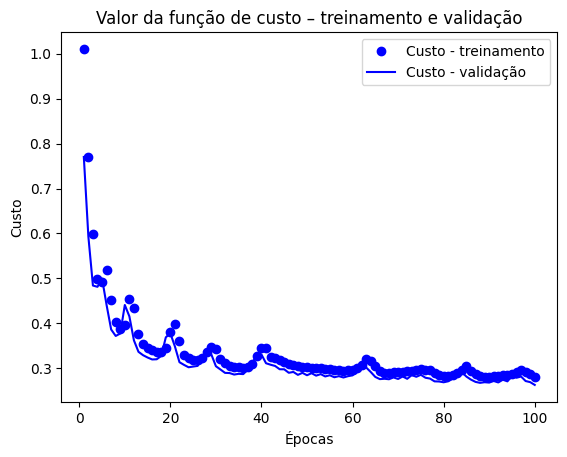

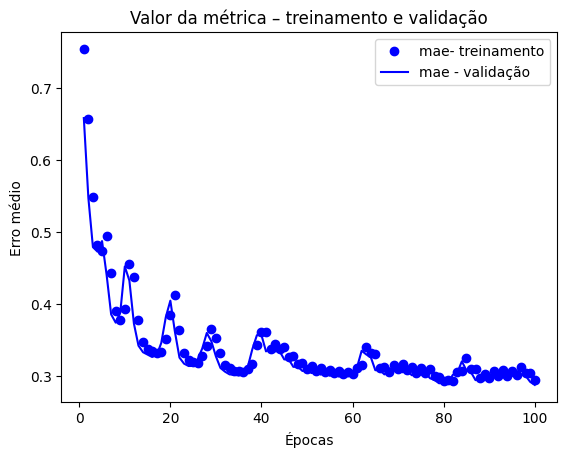

In [59]:
# Salva custos, métricas e epocas em vetores 
custo = history_dict['loss']
mae = history_dict['mae']
val_custo = history_dict['val_loss']
val_mae = history_dict['val_mae']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, mae, 'bo', label='mae- treinamento')
plt.plot(epocas, val_mae, 'b', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()


Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- O treinamento da RNA está sendo efetivo, pois o valor da função de custo e do erro absoluto médio diminuem o tempo todo durante o treinamento, tanto para os dados de treinamento com de validação.
- Os resultados obtidos para os dados de treinamento e de validação são praticamente iguais.
- Os parâmetros da RNA ainda não convergiram para os seus valores ótimos, ainda seriam necessárias muitas épocas para finalizar o treinamento.

### Exercício #7: 

O desempenho real da RNA deve ser verificado com os dados de teste. Para fazer isso, calcule os valores da função de custo e da métrica para os dados de teste.

In [60]:
# PARA VOCÊ FAZER: calculo do custo e métrica para os dados de treinamento, validação e teste

# Usando o método evaluate calcule o custo e a exatidão e depois apresente os resultados
### COMECE AQUI ### (≈ 3 linhas)
custo_e_metricas_train = rna.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rna.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rna.evaluate(x_test_norm, y_test_norm)
### TERMINE AQUI ###

print('Resultado dados treinamento =',custo_e_metricas_train)
print('Resultado dados validação =',custo_e_metricas_val)
print('Resultado dados teste =',custo_e_metricas_test)


 121/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.2693 - mae: 0.2869

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - loss: 0.2774 - mae: 0.2901
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.2618 - mae: 0.2874
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.2815 - mae: 0.2924
Resultado dados treinamento = [0.27759814262390137, 0.291204571723938]
Resultado dados validação = [0.2631525695323944, 0.28727957606315613]
Resultado dados teste = [0.2798532247543335, 0.2916509509086609]


**Saída esperada:**

    38374/38374 [==============================] - 1s 31us/sample - loss: 0.6482 - mean_absolute_error: 0.5988
    10000/10000 [==============================] - 0s 28us/sample - loss: 0.6421 - mean_absolute_error: 0.5989
    10000/10000 [==============================] - 0s 28us/sample - loss: 0.6333 - mean_absolute_error: 0.5940
    Resultado dados treinamento = [0.6481538165098383, 0.598757]
    Resultado dados validação = [0.642096220111847, 0.5989273]
    Resultado dados teste = [0.6333360802650452, 0.59399813]

Você deve observar que o desempenho da RNA nos dados de teste é praticamente o mesmo que o obtido para os dados de treinamento e de validação.

### Para você fazer após entregar o trabalho:

Altere o tamanho da batelada para algo entre 32 e 128 e execute o treinamento novamente usando 1000 épocas. Mas para isso comece de novo do item 3, senão a rede vai continuar o treinamento e você irá concluir erroneamente que diminuindo o tamanho da batelada o treinamento é melhor.

## 4.2 - Gradiente descendente com momento

### Exercício #8: 

Agora você vai treinar a sua RNA usando o método de otimização do gradiente descentende com momento. Assim, na célula abaixo, configure uma nova RNA (use um nome diferente da RNA anterior), com o mesmo números de neurônios nas 5 camadas, usando a função build_model. Depois compile e treine a sua nova RNA usando os seguinte hiperparâmetros:

- método do gradiente descendente com momento;
- constante beta1 = 0,9;
- taxa de aprendizagem = 0,01;
- decaimento da taxa de apredizagem = 1e-03;
- número de épocas = 100;
- batch_size = 128;
- verbose = 0.

In [61]:
# PARA VOCÊ FAZER: Configuração, compilação e treinamento da RNA usando o método do gradiente descendente com momento

# Configuração da RNA
#del rnaM # se for repetir o treinamente retire o comentário desse comando e delete a RNA anterior, senão o treinamento começa de onde parou#### COMECE AQUI ### (≈ 2 linhas)
### COMECE AQUI ### (≈ 1 linha)
rnaM = build_model(data_shape, n1, n2, n3, n4, n5)
### TERMINE AQUI ###

# Configuração do tomizador
### COMECE AQUI ### (≈ 2 linhas)
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)
rnaM.compile(optimizer=opt, loss='mse', metrics=['mae'])
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
historyM = rnaM.fit(x_train_norm, y_train_norm, epochs=100, batch_size=128, validation_data=(x_val_norm, y_val_norm))
### TERMINE AQUI ###


Epoch 1/100


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4993 - mae: 0.4547 - val_loss: 0.2783 - val_mae: 0.2984
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2908 - mae: 0.2933 - val_loss: 0.2587 - val_mae: 0.2786
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2753 - mae: 0.2822 - val_loss: 0.2500 - val_mae: 0.2658
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2618 - mae: 0.2697 - val_loss: 0.2455 - val_mae: 0.2724
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2575 - mae: 0.2680 - val_loss: 0.2355 - val_mae: 0.2571
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2438 - mae: 0.2614 - val_loss: 0.2323 - val_mae: 0.2541
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2380 - mae: 0.2578 - val_loss: 0.2377 - val_mae: 0.2674
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2367 - mae: 0.2590 - val_loss: 0.2207 - val_mae: 0.2523
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:


### Análise dos resultados

Execute as três células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação, e calcular o custo e o erro absoluto médio para os dados de teste.

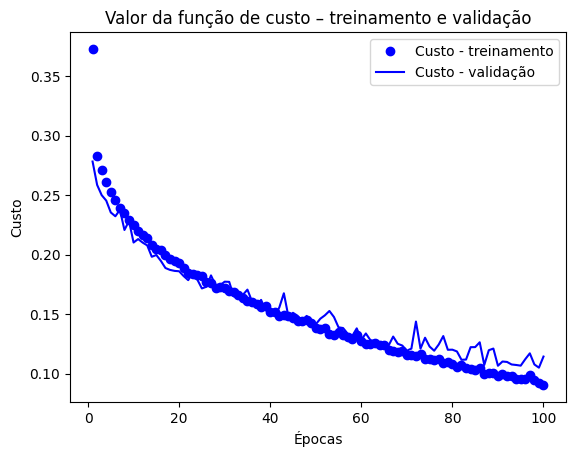

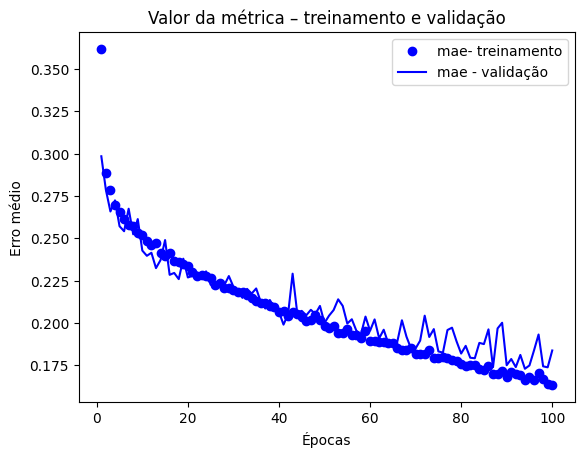

In [62]:
# Salva treinamento na variável history para visualização
history_dictM = historyM.history
history_dictM.keys()

# Salva custos, métricas e epocas em vetores 
custoM = history_dictM['loss']
maeM = history_dictM['mae']
val_custoM = history_dictM['val_loss']
val_maeM = history_dictM['val_mae']

# Cria vetor de épocas
epocasM = range(1, len(custoM) + 1)

# Gráfico dos valores de custo
plt.plot(epocasM, custoM, 'bo', label='Custo - treinamento')
plt.plot(epocasM, val_custoM, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocasM, maeM, 'bo', label='mae- treinamento')
plt.plot(epocasM, val_maeM, 'b', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()


In [63]:
# Calculo do custo e a exatidão para os dados de treinamemto, validação e teste
custo_e_metricas_train = rnaM.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rnaM.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rnaM.evaluate(x_test_norm, y_test_norm)

print('Resultado dados treinamento =',custo_e_metricas_train)
print('Resultado dados validação =',custo_e_metricas_val)
print('Resultado dados teste =',custo_e_metricas_test)


 129/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0963 - mae: 0.1731

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - loss: 0.0986 - mae: 0.1718
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.1136 - mae: 0.1840
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.1156 - mae: 0.1845
Resultado dados treinamento = [0.10003768652677536, 0.17198926210403442]
Resultado dados validação = [0.1142476424574852, 0.18373540043830872]
Resultado dados teste = [0.12179972231388092, 0.18670928478240967]


**Saída esperada:**

    38374/38374 [==============================] - 1s 33us/sample - loss: 0.1714 - mean_absolute_error: 0.2168
    10000/10000 [==============================] - 0s 28us/sample - loss: 0.1765 - mean_absolute_error: 0.2209
    10000/10000 [==============================] - 0s 29us/sample - loss: 0.1852 - mean_absolute_error: 0.2235
    Resultado dados treinamento = [0.17141878408402036, 0.2168142]
    Resultado dados validação = [0.1764663903594017, 0.2208522]
    Resultado dados teste = [0.18515024757385254, 0.22352462]

Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- O treinamento da RNA usando o método do gradiente descendente com momento é mais efetivo do que sem momento, isso pode ser observado pelos valores da função de custo e da métrica que atingiram valores bem menores, tanto para os dados de treinamento com de validação.
- Os parâmetros da RNA ainda não convergiram para os seus valores ótimos, ainda seriam necessárias algumas épocas para finalizar o treinamento.
- O erro absoluto médio é da ordem de 22% para os dados de treinamento, validação e teste. Isso pode ser considerado um bom resultado, dado a complexidade do problema e o número pequeno de épocas de treinamento. 

### 4.3 - RMSprop

### Exercício #9: 

Agora você vai treinar a sua RNA usando o método de otimização RMSprop. Assim, na célula abaixo, configure uma nova RNA (use um nome diferente da RNA anterior), com o mesmo números de neurônios nas 5 camadas, usando a função build_model. Depois compile e treine a sua nova RNA usando os seguinte hiperparâmetros:

- método de otimização RMSprop;
- constante beta2 = 0,9;
- taxa de aprendizagem = 0,01;
- decaimento da taxa de apredizagem = 0;
- número de épocas = 100;
- batch_size = 128;
- verbose = 0.

In [64]:
# PARA VOCÊ FAZER: Configuração, compilação e treinamento da RNA usando o método RMSprop

# Configuração da RNA
# del rnaR # se for repetir o treinamente retire o comentário desse comando e delete a RNA anterior, senão o treinamento começa de onde parou#### COMECE AQUI ### (≈ 2 linhas)
### COMECE AQUI ### (≈ 1 linha)
rnaR = build_model(data_shape, n1, n2, n3, n4, n5)
### TERMINE AQUI ###

# Configuração do tomizador
### COMECE AQUI ### (≈ 2 linhas)
opt = optimizers.RMSprop(learning_rate=0.01)
rnaR.compile(optimizer=opt, loss='mse', metrics=['mae'])
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
historyR = rnaR.fit(x_train_norm, y_train_norm, epochs=100, batch_size=128, validation_data=(x_val_norm, y_val_norm))
### TERMINE AQUI ###


Epoch 1/100


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9170 - mae: 0.5068 - val_loss: 0.2965 - val_mae: 0.3213
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3116 - mae: 0.3217 - val_loss: 0.2607 - val_mae: 0.3046
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2854 - mae: 0.2959 - val_loss: 0.2418 - val_mae: 0.2685
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2594 - mae: 0.2830 - val_loss: 0.2409 - val_mae: 0.2743
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2388 - mae: 0.2696 - val_loss: 0.2585 - val_mae: 0.2817
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2341 - mae: 0.2622 - val_loss: 0.2356 - val_mae: 0.2652
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2312 - mae: 0.2594 - val_loss: 0.2031 - val_mae: 0.2507
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2166 - mae: 0.2535 - val_loss: 0.1984 - val_mae: 0.2485
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

### Análise dos resultados

Execute as três células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação, e calcular o custo e o erro absoluto médio para os dados de teste.

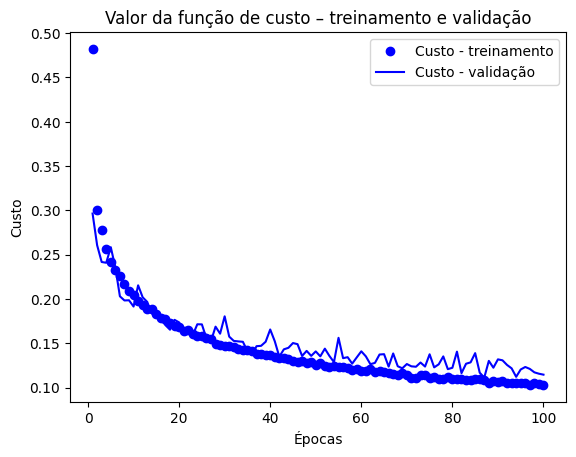

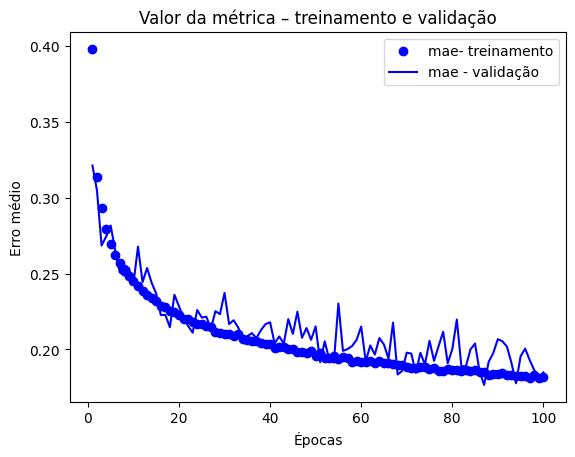

In [65]:
# Salva treinamento na variável history para visualização
history_dictR = historyR.history
history_dictR.keys()

# Salva custos, métricas e epocas em vetores 
custoR = history_dictR['loss']
maeR = history_dictR['mae']
val_custoR = history_dictR['val_loss']
val_maeR = history_dictR['val_mae']

# Cria vetor de épocas
epocasR = range(1, len(custoR) + 1)

# Gráfico dos valores de custo
plt.plot(epocasR, custoR, 'bo', label='Custo - treinamento')
plt.plot(epocasR, val_custoR, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocasR, maeR, 'bo', label='mae- treinamento')
plt.plot(epocasR, val_maeR, 'b', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()


In [66]:
# Calculo do custo e a exatidão para os dados de treinamemto, validação e teste
custo_e_metricas_train = rnaR.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rnaR.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rnaR.evaluate(x_test_norm, y_test_norm)

print('Resultado dados treinamento =',custo_e_metricas_train)
print('Resultado dados validação =',custo_e_metricas_val)
print('Resultado dados teste =',custo_e_metricas_test)


 133/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.0925 - mae: 0.1707

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.0942 - mae: 0.1712
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.1134 - mae: 0.1851
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.1161 - mae: 0.1853
Resultado dados treinamento = [0.09534693509340286, 0.17187261581420898]
Resultado dados validação = [0.11468997597694397, 0.18476513028144836]
Resultado dados teste = [0.11979864537715912, 0.18664835393428802]


**Saída esperada:**

    38374/38374 [==============================] - 1s 32us/sample - loss: 0.1122 - mean_absolute_error: 0.1864
    10000/10000 [==============================] - 0s 28us/sample - loss: 0.1336 - mean_absolute_error: 0.1996
    10000/10000 [==============================] - 0s 29us/sample - loss: 0.1399 - mean_absolute_error: 0.2008
    Resultado dados treinamento = [0.11219662647687942, 0.18639793]
    Resultado dados validação = [0.1336415499985218, 0.19961879]
    Resultado dados teste = [0.13994613930284977, 0.20079675]


Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- O treinamento da RNA usando o método RMSprop é mais rápido do que os dois métodos anteriores (SGD e  GD com Momento), como pode ser observado pelos valores da função de custo e da métrica que convergem rapidamente para um valor constante.
- Os resultados obtidos para os dados de treinamento, validação e teste são semelhantes.
- Os parâmetros da RNA quase convergiram, mas a RNA não apresenta um desempenho muito satisfatório.
- O erro absoluto médio é da ordem de 19% para os dados de treinamento e de 20% para os dados de validação e de teste. Isso pode ser considerado um resultado médio, dado a complexidade do problema.
- O erro absoluto médio para os dados de teste são da mesma ordem de grandeza do obtido para os dados de validação.

### 4.4 - ADAM

### Exercício #10: 

Agora você vai treinar a sua RNA usando o método de otimização ADAM. Assim, na célula abaixo, configure uma nova RNA (use um nome diferente da RNA anterior), com o mesmo números de neurônios nas 5 camadas, usando a função build_model. Depois compile e treine a sua nova RNA usando os seguinte hiperparâmetros:

- método de otimização RMSprop;
- constante beta1 = 0,9;
- constante beta2 = 0.99;
- taxa de aprendizagem = 0,01;
- decaimento da taxa de apredizagem = 0;
- número de épocas = 100;
- batch_size = 128;
- verbose = 0.

In [67]:
# PARA VOCÊ FAZER: Configuração, compilação e treinamento da RNA usando o método ADAM

# Reinicializa o gerador de números aleatórios
np.random.seed(8)

# Configuração da RNA
#del rnaR # se for repetir o treinamente retire o comentário desse comando e delete a RNA anterior, senão o treinamento começa de onde parou#### COMECE AQUI ### (≈ 2 linhas)
### COMECE AQUI ### (≈ 1 linha)
rnaA = build_model(data_shape, n1, n2, n3, n4, n5)
### TERMINE AQUI ###

# Configuração do otimizador
### COMECE AQUI ### (≈ 2 linhas)
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
rnaA.compile(optimizer=opt, loss='mse', metrics=['mae'])
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
historyA = rnaA.fit(x_train_norm, y_train_norm, epochs=100, batch_size=128, validation_data=(x_val_norm, y_val_norm))
### TERMINE AQUI ###


Epoch 1/100


300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3982 - mae: 0.3854 - val_loss: 0.2891 - val_mae: 0.2951
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2805 - mae: 0.2951 - val_loss: 0.2663 - val_mae: 0.3057
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2808 - mae: 0.2969 - val_loss: 0.2755 - val_mae: 0.2965
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2627 - mae: 0.2836 - val_loss: 0.2402 - val_mae: 0.2664
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2424 - mae: 0.2689 - val_loss: 0.2246 - val_mae: 0.2617
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2275 - mae: 0.2615 - val_loss: 0.2213 - val_mae: 0.2529
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2238 - mae: 0.2567 - val_loss: 0.2101 - val_mae: 0.2600
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2182 - mae: 0.2540 - val_loss: 0.2139 - val_mae: 0.2585
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss:

### Análise dos resultados

Execute as três células a seguir para fazer os gráficos da função de custo e da métrica (erro absoluto médio) para os dados de treinamento e validação, e calcular o custo e o erro absoluto médio para os dados de teste.

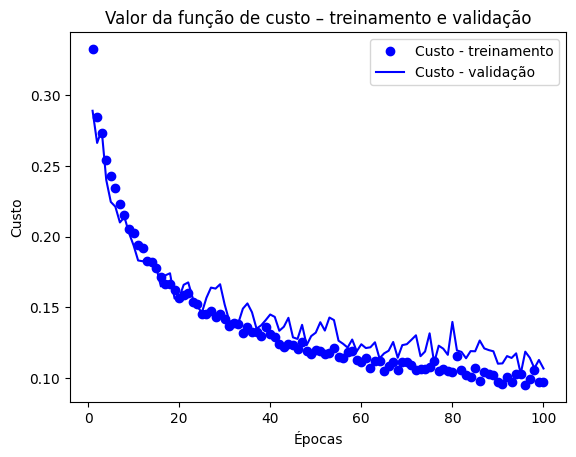

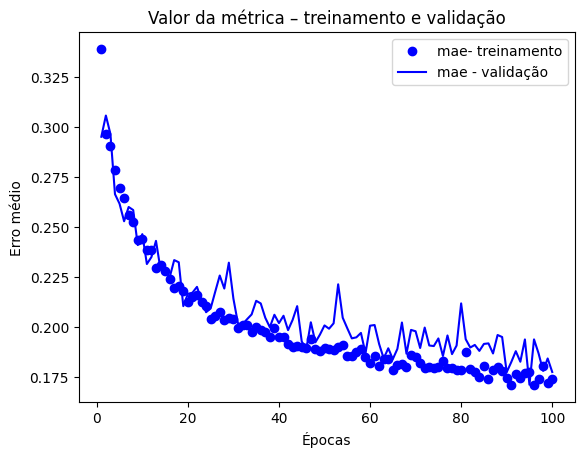

In [68]:
history_dictA = historyA.history
history_dictA.keys()

# Salva custos, métricas e epocas em vetores 
custoA = history_dictA['loss']
maeA = history_dictA['mae']
val_custoA = history_dictA['val_loss']
val_maeA = history_dictA['val_mae']

# Cria vetor de épocas
epocasA = range(1, len(custoA) + 1)

# Gráfico dos valores de custo
plt.plot(epocasA, custoA, 'bo', label='Custo - treinamento')
plt.plot(epocasA, val_custoA, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocasA, maeA, 'bo', label='mae- treinamento')
plt.plot(epocasA, val_maeA, 'b', label='mae - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Erro médio')
plt.legend()
plt.show()


In [69]:
# Calculo do custo e a exatidão para os dados de treinamemto, validação e teste
custo_e_metricas_train = rnaA.evaluate(x_train_norm, y_train_norm)
custo_e_metricas_val = rnaA.evaluate(x_val_norm, y_val_norm)
custo_e_metricas_test = rnaA.evaluate(x_test_norm, y_test_norm)

print('Resultado dados treinamento =',custo_e_metricas_train)
print('Resultado dados validação =',custo_e_metricas_val)
print('Resultado dados teste =',custo_e_metricas_test)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - loss: 0.0860 - mae: 0.1633
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.1074 - mae: 0.1785
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.1116 - mae: 0.1772
Resultado dados treinamento = [0.08780185878276825, 0.16424015164375305]
Resultado dados validação = [0.10685504227876663, 0.17751680314540863]
Resultado dados teste = [0.11226467043161392, 0.17703506350517273]


**Saída esperada:**

    38374/38374 [==============================] - 2s 40us/sample - loss: 0.0955 - mean_absolute_error: 0.1730
    10000/10000 [==============================] - 0s 36us/sample - loss: 0.1158 - mean_absolute_error: 0.1853
    10000/10000 [==============================] - 0s 28us/sample - loss: 0.1237 - mean_absolute_error: 0.1870
    Resultado dados treinamento = [0.09552695891666656, 0.17295344]
    Resultado dados validação = [0.11576385102272034, 0.18530796]
    Resultado dados teste = [0.12371257846951485, 0.18703184]

Dos gráficos dos valores da função de custo e da métrica você pode concluir o seguinte:

- Pelos gráficos da função de custo e da métrica, o treinamento da RNA usando o método ADAM obteve resultados um pouco melhor do que os obtidos com os três métodos anteriores (GD, SGD com Momento e RMSprop).
- Os resultados obtidos para os dados de treinamento são um pouco melhores do que para os dados de validação e de teste.
- Os parâmetros da RNA ainda não convergiram para os seus valores ótimos, ainda seriam necessárias algumas épocas para finalizar o treinamento.
- O erro absoluto médio é da ordem de 17% para os dados de treinamento de 19% para os dados de validação e teste. Isso pode ser considerado um resultado médio, dado a complexidade do problema e o número pequeno de épocas de treinamento. 
- O erro basoluto médio para os dados de teste são semelhantes aos obtidos para os dados de validação.

### 4.5 - Resumo dos resultados

A tabela apresenta os resultados obtidos pelos diversos métodos de otimização para os dados de teste.
<table> 
    <tr>
        <td>
        Método de otimização
        </td>
        <td>
        Erro absoluto médio
        </td>
        <td>
        Função de custo
        </td>

   </tr>
        <td>
        Gradiente Descendente
        </td>
        <td>
        59,4%
        </td>
        <td>
        0,633
        </td>
    <tr>
        <td>
        GD com momento
        </td>
        <td>
        22,4%
        </td>
        <td>
        0,185
        </td>
    </tr>
    
   <tr>
        <td>
        RMSprop
        </td>
        <td>
        20,1%
        </td>
        <td>
        0,140
        </td>
    </tr>    
    
    
   <tr>
        <td>
        Adam
        </td>
        <td>
        18,7%
        </td>
        <td>
        0,124
        </td>
    </tr>
</table> 

Por esses resultados pode-se conluir que o desemepnho da RNA não é satisfatório. Mas isso é certamente causado pelo fato de que não tentamos otimizar os hiperparâmetros da rede. Se tivéssemos feito alguns ajustes, tais como, aumentar número de camadas, aumentar número de neurônios, aumentar número de épocas de treinamento, testar diferentes taxas de amostragem, certamente os resultados seriam muito melhores.

### 5 - Cálculo das saídas previstas

### Exercício #11: 

Calcule as saídas previstas pela RNA para os exemplos de teste. Para isso execute a sua RNA treinada pelo método do GD com momento e depois faça os gráficos dos resulyados obtidos para os 100 primeiros exemplos de teste. Implemente o seu código na célula abaixo.

 36/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


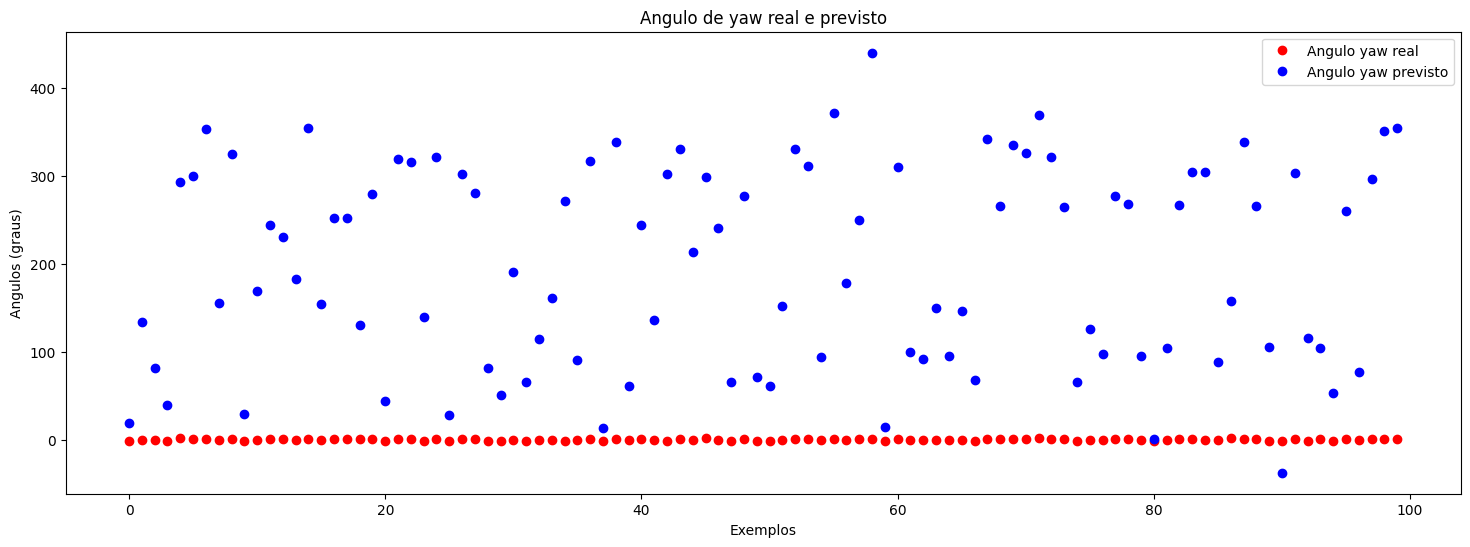

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


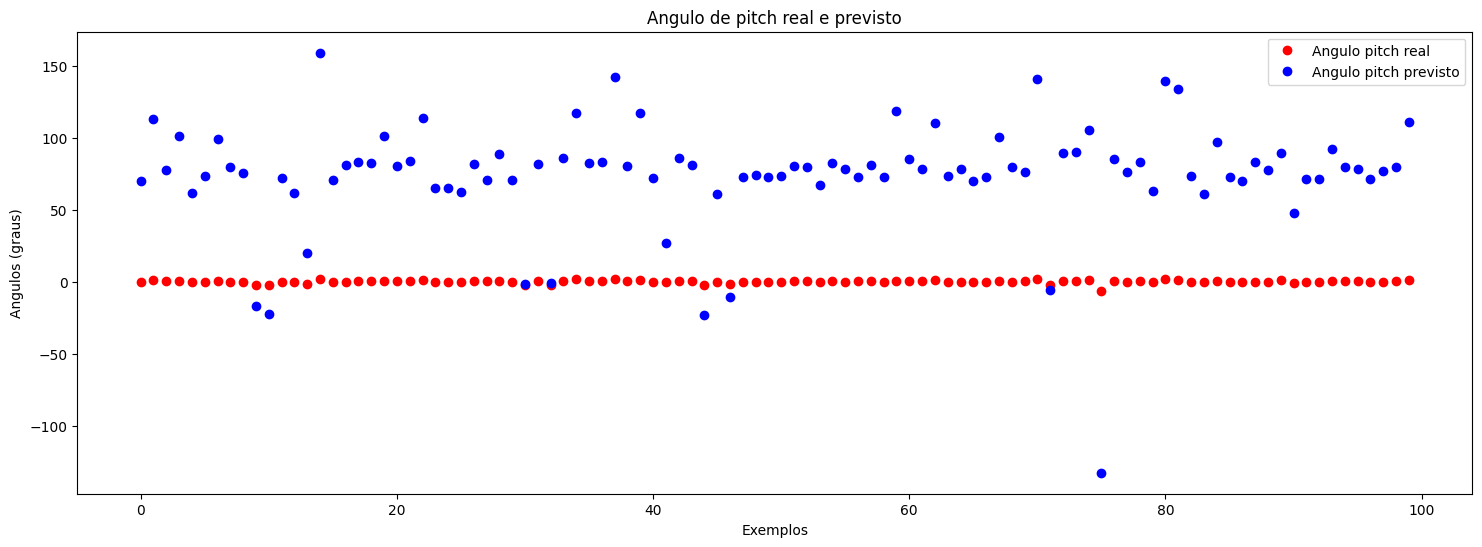

In [71]:
# PARA VOCÊ FAZER: calculo e gráfico das saídas previstas para os dados de teste

# Usando método predict calcule as classes previstas
### COMECE AQUI ### (≈ 2 linhas)
y_prev = rnaA.predict(x_test_norm)
y_prev = y_prev * stdy + meany
### TERMINE AQUI ###

# Gráfico dos ângulos de yaw reais e previstos para os primeiros 100 exemplos
plt.figure(figsize=(18, 6))
plt.plot(y_test_norm[:100,0], 'ro', label='Angulo yaw real')
plt.plot(y_prev[:100,0], 'bo', label='Angulo yaw previsto')
plt.title('Angulo de yaw real e previsto')
plt.xlabel('Exemplos')
plt.ylabel('Angulos (graus)')
plt.legend()
plt.show()

# Gráfico dos ângulos de pitch reais e previstos para os primeiros 100 exemplos
### COMECE AQUI ### (≈ 8 linhas)
y_prev_a = rnaA.predict(x_test_norm)
y_prev_a = y_prev_a * stdy + meany
plt.figure(figsize=(18, 6))
plt.plot(y_test_norm[:100,1], 'ro', label='Angulo pitch real')
plt.plot(y_prev_a[:100,1], 'bo', label='Angulo pitch previsto')
plt.title('Angulo de pitch real e previsto')
plt.xlabel('Exemplos')
plt.ylabel('Angulos (graus)')
plt.legend()
plt.show()
### TERMINE AQUI ###

# Gráfico dos ângulos de roll reais e previstos para os primeiros 100 exemplos
### COMECE AQUI ### (≈ 8 linhas)
#
### TERMINE AQUI ###


### Análise dos resultados:

Pelos gráficos acima pode-se facilmente verificar que os resultados obttidos não são bons e que falta ainda muito trabalho para se obter uma solução com desempenho satisfatório.

## Para você fazer após entregar o trabalho:

Para melhorar os resultados da sua RNA você pode tentar diversas coisas, tais como:

- Aumentar o número de camadas e neurônios da RNA;
- Utilizar um número maior de épocas de treinamento;
- Alterar o tamanho da mini-batelada;
- Usar decaimento da taxa de aprendizado;
- Testar outros valores para os hiperparâmetros dos otimizadores.

Tente fazer algumas dessas coisas e veja se consegue obter resultados melhores. 